## Objective

To predict the concrete strength using the data available in file concrete_data.xls. Apply
feature engineering and model tuning to obtain 80% to 95% of R2score.

In [1]:
##importing libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

In [2]:
### reading data
df_concrete = pd.read_csv('concrete.csv')

df_concrete.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [3]:
df_concrete.shape

(1030, 9)

In [4]:
df_concrete.dtypes

cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
strength        float64
dtype: object

## Univariate Analysis

In order to understand this dataset, let's check how data is distrubuted.

In [5]:
df_concrete.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


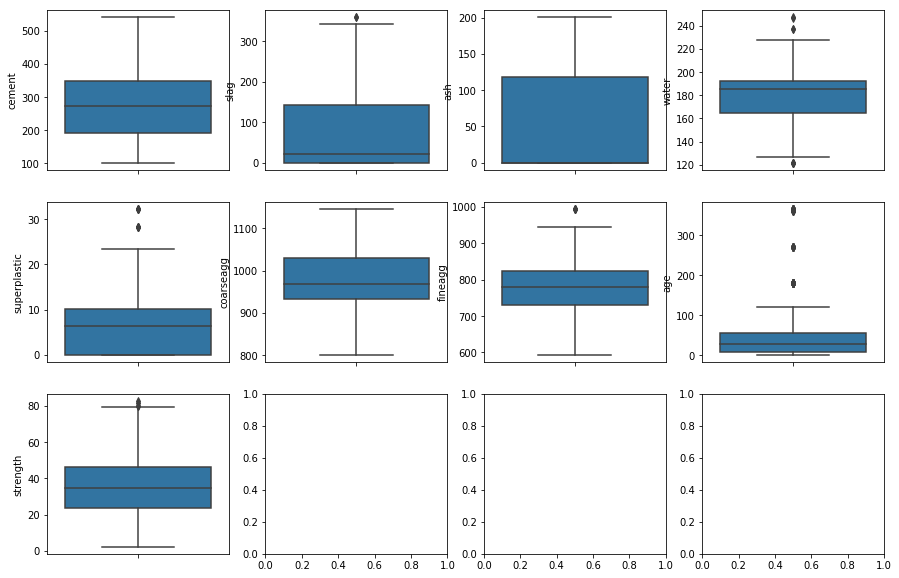

In [6]:
fix, ax = plt.subplots(3,4, figsize=(15,10))
for var, subplot in zip(df_concrete.columns, ax.flatten()):
    sns.boxplot(y=var, data=df_concrete, ax=subplot)

By this plots we can see that a few outliers is noticed on slag, water, superplastic, fineagge and age variables.

Let's check now the data against the predictor variable and some correlation between them.

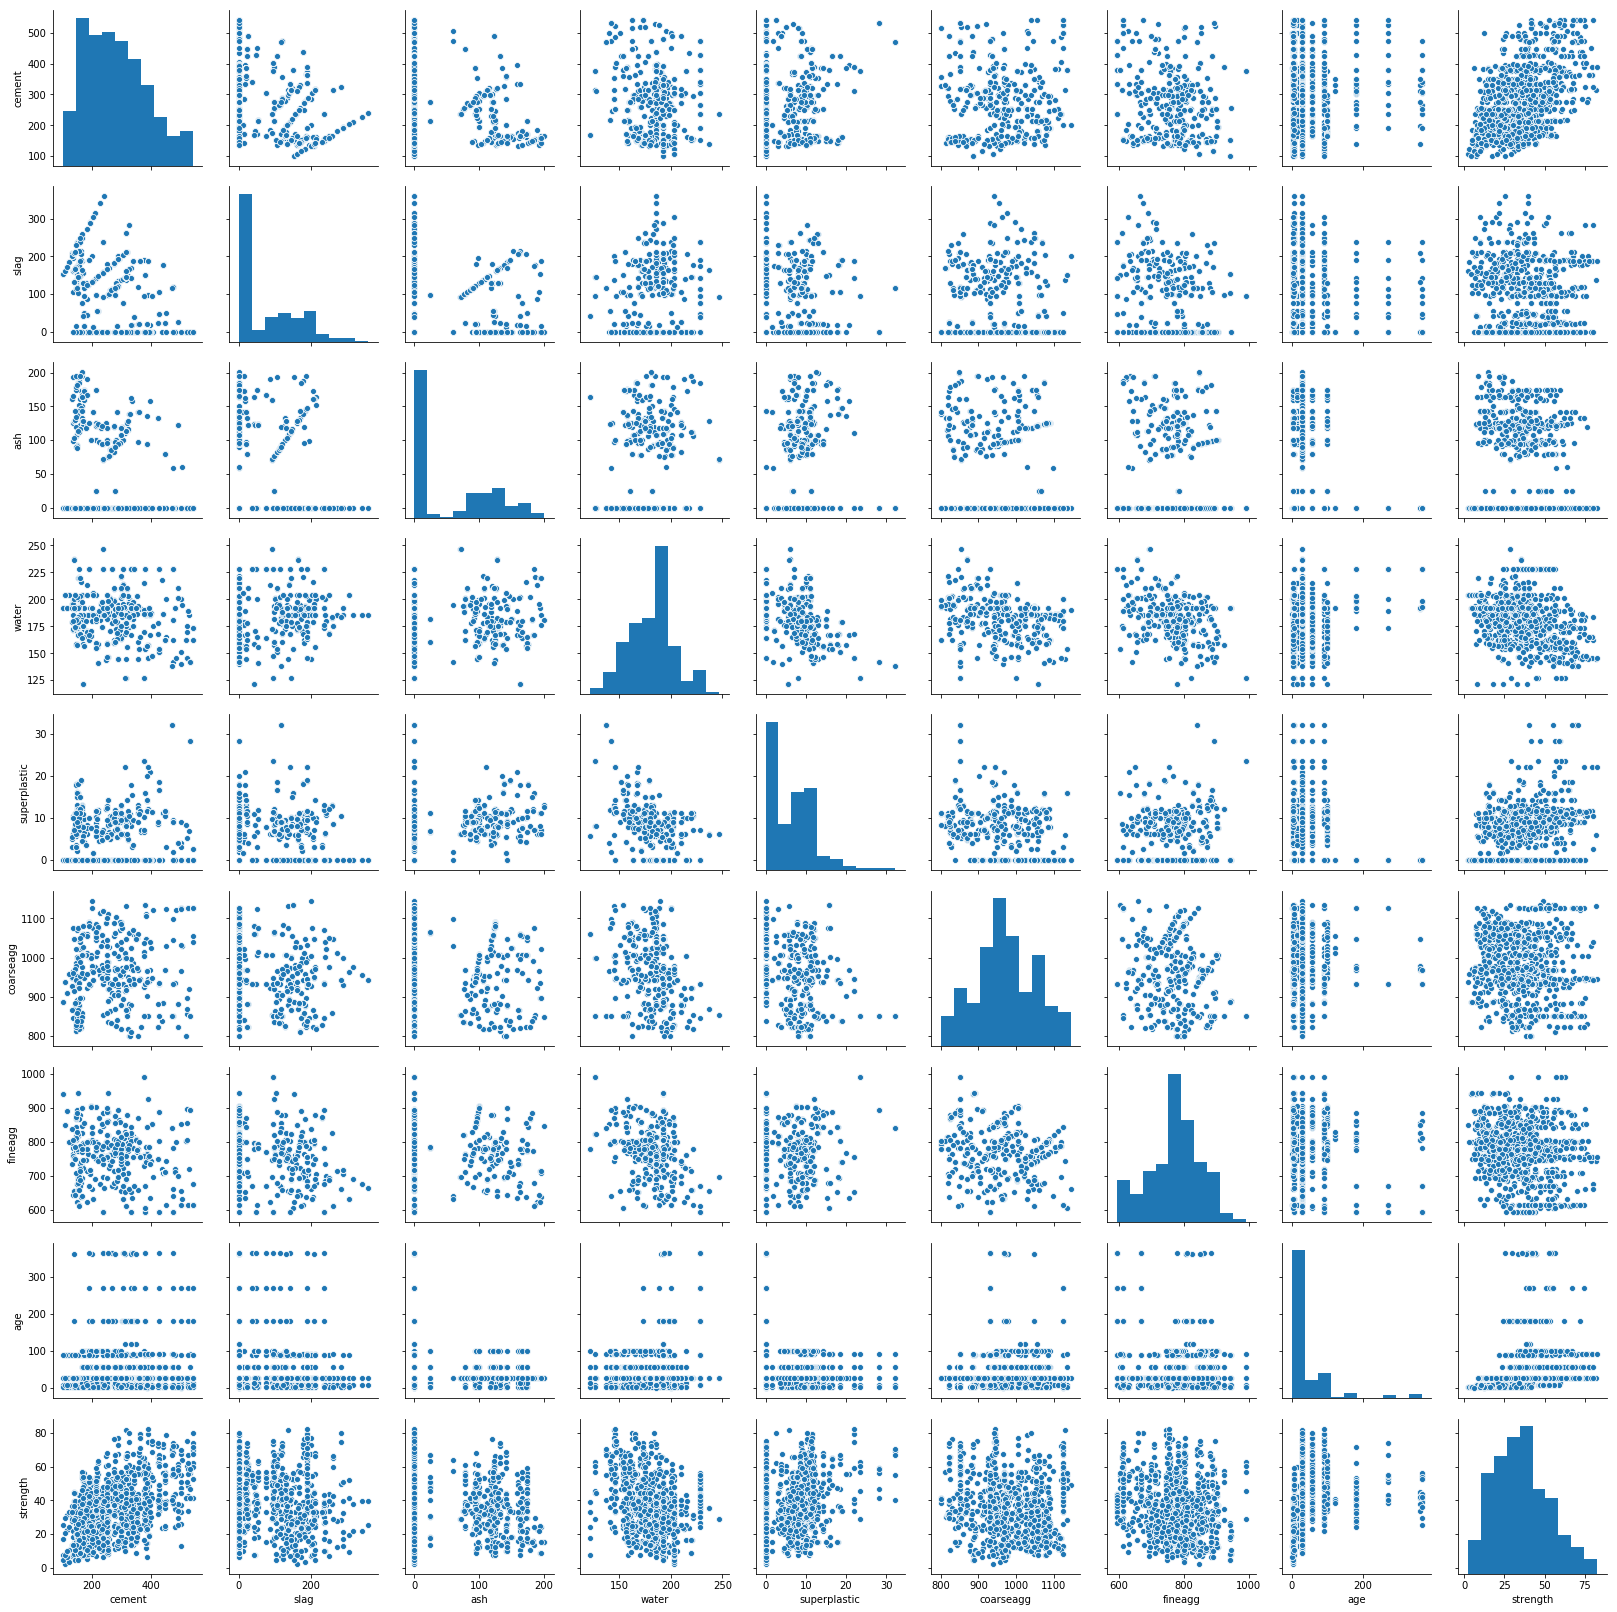

In [7]:
sns.pairplot(df_concrete)

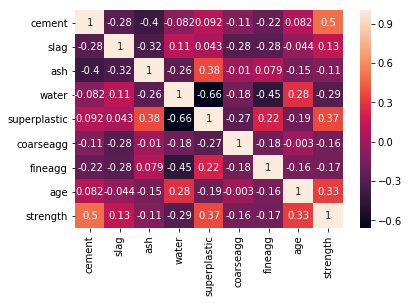

In [8]:
sns.heatmap(df_concrete.corr(), annot=True)

Ok, now we can have a big picture of what is going on. So far, we can seen there is no case of multicolinearity for these variables. <b>Cement</b> is the variable that has the greatest correlation with strengh.
The lowest correlation is given by <b>water</b> variable. The other ones have almost null efect on cement. 

So, I'll try to use PCA to reduce the number of variables for just 6

## Feature Engineering

Reducing the number of variables to the more important ones.

In [9]:
pca = PCA(n_components=None)

principalComponents = pca.fit_transform(df_concrete.drop('strength', axis=1))


pca.explained_variance_ratio_


array([3.25768164e-01, 2.48874326e-01, 1.84797599e-01, 1.07659422e-01,
       1.00949461e-01, 2.98453656e-02, 1.81795868e-03, 2.87704080e-04])

In [10]:
pca = PCA(n_components=6)

principalComponents = pca.fit_transform(df_concrete.drop('strength', axis=1))

principalComponentsDf = pd.DataFrame(data=principalComponents, columns=['pca1','pca2','pca3','pca4','pca5','pca6'])

principalComponentsDf['strength'] = df_concrete.strength

principalComponentsDf.head()

,pca1,pca2,pca3,pca4,pca5,pca6,strength
0,-146.329872,132.488478,-22.222572,-51.581979,-1.643203,30.128494,29.89
1,-119.063970,-93.652456,-86.724654,-13.026131,-29.746026,-26.449440,23.51
2,-38.697563,-107.561449,55.183273,6.861777,1.924107,10.624516,29.22
3,9.328389,107.708492,-28.747997,25.938040,-15.045841,79.122384,45.85
4,-116.465771,112.215155,-110.723487,-57.745690,-14.501044,25.941205,18.29


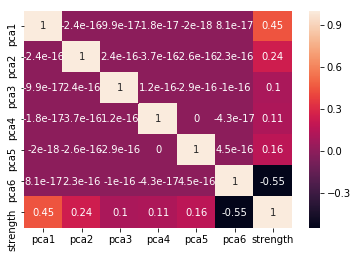

In [11]:
sns.heatmap(principalComponentsDf.corr(), annot=True)

Now we have better data, that is low correlation between the X variables and some correlation with <b>strength</b>, our Y variable.

In [12]:
y = principalComponentsDf.strength

x = df_concrete.drop('strength', axis=1)
#x = principalComponentsDf.drop('strength', axis=1) #(changed because PCA was giving worst results than _
                                                    #using the entire features)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

## Model testing - Decision Tree

Using decision tree as a baseline model

In [13]:
clr = DecisionTreeRegressor(random_state=123)
clr.fit(X_train, y_train)


df_models = pd.DataFrame({'Model':'Tunned Adaboosting - RandomSearch', 'Score on train': clr.score(X_train, y_train), 
 'Score on test':clr.score(X_test, y_test), 'inf':0, 'sup':0}, index=[0])

print('R2 on train data', clr.score(X_train, y_train))
print('R2 on test data',clr.score(X_test, y_test))



R2 on train data 0.9962578058267287
R2 on test data 0.8421030961298019


Let`s avoid this overfitting by pruning the tree.

In [14]:
clr = DecisionTreeRegressor(random_state=123, max_depth=5)
clr.fit(X_train, y_train)

df_models = df_models.append({'Model':'Tunned Adaboosting - RandomSearch', 'Score on train': clr.score(X_train, y_train), 
 'Score on test':clr.score(X_test, y_test), 'inf':0, 'sup':0}, ignore_index=True)

print('R2 on train data', clr.score(X_train, y_train))
print('R2 on test data',clr.score(X_test, y_test))

R2 on train data 0.8227190098281545
R2 on test data 0.7546489548773863


In [15]:
### Tunned Decision Tree
param_dist = {"criterion": ['mse', 'friedman_mse','mae'],
              "splitter" : ['best','random'],
              "max_depth": sp_randint(1, 20),
              "max_features": sp_randint(1, 6),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11)}

tun_clr = DecisionTreeRegressor(random_state=123)

samples = 20
TreeCV = RandomizedSearchCV(tun_clr, param_distributions=param_dist, n_iter=samples)

TreeCV.fit(X_train, y_train)
print(TreeCV.best_params_)

/Users/reinaldodeoliveiramaciel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'mse', 'max_depth': 11, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


/Users/reinaldodeoliveiramaciel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


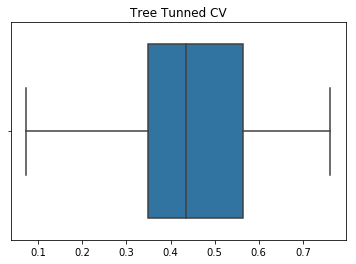

In [16]:
ci_inf = np.mean(TreeCV.cv_results_['mean_test_score']) - (1.96*np.std(TreeCV.cv_results_['mean_test_score']))
ci_sup = np.mean(TreeCV.cv_results_['mean_test_score']) + (1.96*np.std(TreeCV.cv_results_['mean_test_score']))

ax = sns.boxplot(TreeCV.cv_results_['mean_test_score'])
ax = ax.set_title('Tree Tunned CV')

In [17]:
Tree_tunned = DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=5,min_samples_leaf=1,
                            min_samples_split=6, splitter='best')

Tree_tunned.fit(X_train, y_train)


df_models = df_models.append({'Model':'Tunned Tree - RandomSearch', 'Score on train': Tree_tunned.score(X_train, y_train), 
 'Score on test':Tree_tunned.score(X_test, y_test), 'inf':ci_inf, 'sup':ci_sup}, ignore_index=True)

### Random Forest

In [18]:
clRF = RandomForestRegressor(n_estimators=20)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [5, None],
              "max_features": sp_randint(1, 6),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False]}

# run randomized search
samples = 20  # number of random samples 
randomCV = RandomizedSearchCV(clRF, param_distributions=param_dist, n_iter=samples)

randomCV.fit(X_train, y_train)
print(randomCV.best_params_)

/Users/reinaldodeoliveiramaciel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'bootstrap': True, 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}


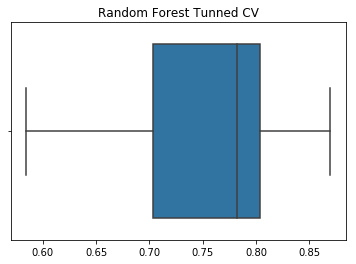

In [19]:
ci_inf = np.mean(randomCV.cv_results_['mean_test_score']) - (1.96*np.std(randomCV.cv_results_['mean_test_score']))
ci_sup = np.mean(randomCV.cv_results_['mean_test_score']) + (1.96*np.std(randomCV.cv_results_['mean_test_score']))

ax = sns.boxplot(randomCV.cv_results_['mean_test_score'])
ax = ax.set_title('Random Forest Tunned CV')

In [20]:
clRF_tunned = RandomForestRegressor(n_estimators=20, bootstrap=True, max_depth=None, max_features=3,min_samples_leaf=1,
                            min_samples_split=3)

clRF_tunned.fit(X_train, y_train)

print('R2 on train data', clRF_tunned.score(X_train, y_train))
print('R2 on test data',clRF_tunned.score(X_test, y_test))


df_models = df_models.append({'Model':'Tunned RandomForest - RandomSearch', 'Score on train': clRF_tunned.score(X_train, y_train), 
 'Score on test':clRF_tunned.score(X_test, y_test), 'inf':ci_inf, 'sup':ci_sup}, ignore_index=True)


R2 on train data 0.9771872016838595
R2 on test data 0.8976234868408032


## Bagging

In [21]:
param_dist = {"n_estimators": sp_randint(2, 20),
              "max_features": sp_randint(1, 6),
              "bootstrap": [True, False]}

bgrs = BaggingRegressor(random_state=123)

samples = 20  # number of random samples 
BaggingCV = RandomizedSearchCV(bgrs, param_distributions=param_dist, n_iter=samples)

BaggingCV.fit(X_train, y_train)
print(BaggingCV.best_params_)

/Users/reinaldodeoliveiramaciel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'bootstrap': False, 'max_features': 5, 'n_estimators': 15}


/Users/reinaldodeoliveiramaciel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


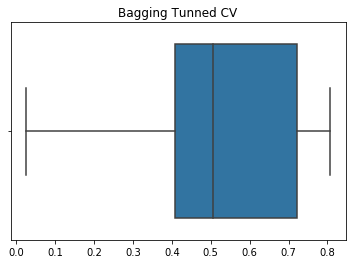

In [22]:
ci_inf = np.mean(BaggingCV.cv_results_['mean_test_score']) - (1.96*np.std(BaggingCV.cv_results_['mean_test_score']))
ci_sup = np.mean(BaggingCV.cv_results_['mean_test_score']) + (1.96*np.std(BaggingCV.cv_results_['mean_test_score']))

ax = sns.boxplot(BaggingCV.cv_results_['mean_test_score'])
ax = ax.set_title('Bagging Tunned CV')

In [23]:
bgrs = BaggingRegressor(bootstrap=False, max_features=5, n_estimators=15)

bgrs = bgrs.fit(X_train, y_train)


df_models = df_models.append({'Model':'Tunned Bagging - RandomSearch', 'Score on train': bgrs.score(X_train, y_train), 
 'Score on test':bgrs.score(X_test, y_test), 'inf':ci_inf, 'sup':ci_sup}, ignore_index=True)

## Adaboost

In [24]:
abcr = AdaBoostRegressor(random_state=123)

param_dist = {"n_estimators": sp_randint(2, 20)}


samples = 20  # number of random samples 
AdaBoostingCV = RandomizedSearchCV(abcr, param_distributions=param_dist, n_iter=samples)

AdaBoostingCV.fit(X_train, y_train)
print(AdaBoostingCV.best_params_)

/Users/reinaldodeoliveiramaciel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 18}


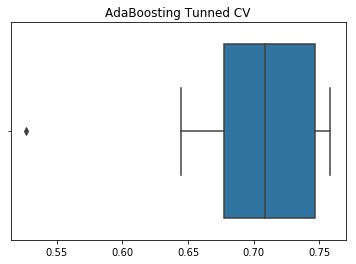

In [25]:
ci_inf = np.mean(AdaBoostingCV.cv_results_['mean_test_score']) - (1.96*np.std(AdaBoostingCV.cv_results_['mean_test_score']))
ci_sup = np.mean(AdaBoostingCV.cv_results_['mean_test_score']) + (1.96*np.std(AdaBoostingCV.cv_results_['mean_test_score']))

ax = sns.boxplot(AdaBoostingCV.cv_results_['mean_test_score'])
ax = ax.set_title('AdaBoosting Tunned CV')

In [26]:
abcr = BaggingRegressor(n_estimators= 19)

abcr = abcr.fit(X_train, y_train)


df_models = df_models.append({'Model':'Tunned Adaboosting - RandomSearch', 'Score on train': abcr.score(X_train, y_train), 
 'Score on test':abcr.score(X_test, y_test), 'inf':ci_inf, 'sup':ci_sup}, ignore_index=True)

In [27]:
df_models

,Model,Score on train,Score on test,inf,sup
0,Tunned Adaboosting - RandomSearch,0.996258,0.842103,0.000000,0.000000
1,Tunned Adaboosting - RandomSearch,0.822719,0.754649,0.000000,0.000000
2,Tunned Tree - RandomSearch,0.974533,0.824130,0.129998,0.753027
3,Tunned RandomForest - RandomSearch,0.977187,0.897623,0.576354,0.923245
4,Tunned Bagging - RandomSearch,0.960204,0.841937,0.104973,0.939288
5,Tunned Adaboosting - RandomSearch,0.980271,0.905616,0.591704,0.811793


Conclusion is that Tunned random forest and Tunned Adaboosting are the best options for this concrete prediction.